# Import libraries

In [14]:
import pandas as pd
import csv
import re
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx 
import spacy


from selenium import webdriver 
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from pyvis.network import Network

#from functions.lotr_functions import *

In [ ]:
def download_characters_from_web_test(page_urls):
  # Create driver
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    actions = ActionChains(driver)

    # list with character's key, name and url to his website
    characters_list = [] 
    # list with book's key and name 
    books_list=[] 
    # pivot-Table with book key and character key
    book_character_list=[] 
    #book key 
    book_index=0
    # character kex for all books
    character_index=0
    
    
    for page_url in page_urls: 
        #open url 
        driver.get(page_url)

        #click accept cookies if popup shows
        #identify element
        coockies=driver.find_elements(By.XPATH, '//div[text()="ANNEHMEN"]')
        if(len(coockies)>0):
            driver.find_element(By.XPATH, '//div[text()="ANNEHMEN"]').click()  
        #save book name
        book_name=driver.find_element(By.CLASS_NAME, 'page-header__title').text

        #find div with characters 
        table_with_characters=driver.find_element(By.CLASS_NAME, 'appearances')
        #find all characters inside of div with characters 
        character_elements=table_with_characters.find_elements(By.TAG_NAME, 'li')

        #save character
        for character in character_elements:

            character_url=character.find_element(By.TAG_NAME, 'a').get_attribute('href')
            character_name=character.find_element(By.TAG_NAME, 'a').text

            #check if addiitional info exists
            additional_info=character.find_elements(By.TAG_NAME, 'small')
            if(len(additional_info)>0):
                character_add_infos=character.find_element(By.TAG_NAME, 'small').text
                character_add_info = character_add_infos.split(", ")
                character_add_info = character_add_infos.replace(") (", ", ").replace(")", "").replace("(", "")
            else:
                character_add_info=None
                 # Load a page 

            #get other names 

            # Open a new window
            driver.execute_script("window.open('');")

            # Switch to the new window and open new URL
            driver.switch_to.window(driver.window_handles[1])
            driver.get(character_url)
            try:
                other_names_section=driver.find_element(By.XPATH, '//div[@data-source="othernames"]')
                other_names_str=other_names_section.find_element(By.CLASS_NAME, 'pi-data-value').text
                other_names_str = re.sub('\[\d\]', '', other_names_str)
                other_names_str=other_names_str.replace(",\n","; ")
                other_names_str=other_names_str.replace("\n","; ")
                other_names_str=other_names_str.replace(", ","; ")
                other_names=other_names_str.split("; ")
            except NoSuchElementException:
                other_names=[]
            # Closing new_url tab
            driver.close()

            # Switching to old tab
            driver.switch_to.window(driver.window_handles[0])        

            #add character to characters_list and to book_character_list 
            if (next((item for item in characters_list if item["character_name"] ==character_name), None))==None: 
                characters_list.append({"character_key": character_index, "character_name": character_name, "character_firstname":character_name.split(' ', 1)[0], "other_names": other_names, "character_url": character_url})
                book_character_list.append({"book_key": book_index, "character_key": character_index, "add_info": character_add_info})
                character_index=character_index+1
            else: 
                book_character_list.append({"book_key": book_index, "character_key": next(item for item in characters_list if item["character_name"] ==character_name)["character_key"], "add_info": character_add_info})

        books_list.append({"key": book_index, "name": book_name})
        book_index=book_index+1
    driver.close()

    characters_list_df=pd.DataFrame(characters_list)
    return characters_list_df

In [23]:
import spacy
def get_book_text(book_name):

    # Load spacy English languague model
    NER=spacy.load("en_core_web_sm")
    book_text = open(book_name).read()
    book_doc = NER(book_text)
    
    return book_doc


In [26]:
def get_entity_list_per_sentence(book_doc):
    sent_entity_df=[]
    # Loop through sentences, store named entity list for each sentence
    for sent in book_doc.sents: 
        entity_list=[ent.text for ent in sent.ents]
        sent_entity_df.append({"sentence": sent, "entities": entity_list})
    sent_entity_df=pd.DataFrame(sent_entity_df) 
    
    return sent_entity_df

In [27]:
import os
def filter_entity(ent_list, character_df): 
    ent_list_finale=[]
    for ent in ent_list:
        if ent in list(character_df.character_name):
            index=list(character_df.character_name).index(ent)
            ent_list_finale.append(character_df.character_name[index])
        elif ent in list(character_df.character_firstname):
            index=list(character_df.character_firstname).index(ent)
            ent_list_finale.append(character_df.character_name[index])
        else: 
            for num, other_names in enumerate(list(character_df.other_names)):
                if ent in other_names: 
                    ent_list_finale.append(character_df.character_name[num])
    return ent_list_finale

           

In [180]:
def create_relationships (df, window_size): 
    
    relationships = []

    for i in range(df.index[-1]):
        end_i = min(i + window_size, df.index[-1])
        char_list = sum((df.loc[i: end_i].character_entities), [])
        
        # Remove duplicated characters that are next to each other
        char_unique = [char_list[i] for i in range(len(char_list)) 
                       if (i==0) or char_list[i] != char_list[i-1]]

        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b})
           
    relationship_df = pd.DataFrame(relationships)
   
    # Sort the cases with a->b and b->a
    relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), 
                                   columns = relationship_df.columns)
    relationship_df["value"] = 1
    relationship_df = relationship_df.groupby(["source","target"], 
                                              sort=False, 
                                              as_index=False).sum()
                
    return relationship_df

# Load characters

In [ ]:
# Create driver
#driver = webdriver.Chrome(ChromeDriverManager().install())
#driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

page_urls = ["https://lotr.fandom.com/wiki/The_Lord_of_the_Rings:_The_Fellowship_of_the_Ring"],  "https://lotr.fandom.com/wiki/The_Lord_of_the_Rings:_The_Two_Towers", "https://lotr.fandom.com/wiki/The_Lord_of_the_Rings:_The_Return_of_the_King"]

characters_list_df = download_characters_from_web_test(page_urls=page_urls)
#save_characters_to_csv(characters_list, 'characters')

[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.79M/6.79M [00:01<00:00, 6.88MB/s]


# Load books

In [7]:
characters_list_df=pd.DataFrame(characters_list_df)
characters_list_df

,character_key,character_name,character_firstname,other_names,character_url
0,0,Albert Dreary,Albert,[],https://lotr.fandom.com/wiki/Albert_Dreary
1,1,Aragorn II Elessar,Aragorn,"[Estel, Thorongil, Elessar (Edhelharn), Telcon...",https://lotr.fandom.com/wiki/Aragorn_II_Elessar
2,2,Arathorn,Arathorn,[],https://lotr.fandom.com/wiki/Arathorn
3,3,Arwen,Arwen,"[Undómiel (Quenya for ""Evenstar"")]",https://lotr.fandom.com/wiki/Arwen
4,4,Balin,Balin,[],https://lotr.fandom.com/wiki/Balin
...,...,...,...,...,...
97,97,Paladin II Took,Paladin,[],https://lotr.fandom.com/wiki/Paladin_II_Took
98,98,Pallando,Pallando,"[Pallando the Blue, Rómestámo, Palacendo]",https://lotr.fandom.com/wiki/Pallando
99,99,Radagast,Radagast,"[Aiwendil, Hrávandil, Tender of Beasts, Bird F...",https://lotr.fandom.com/wiki/Radagast
100,100,Shagrat,Shagrat,[],https://lotr.fandom.com/wiki/Shagrat


In [182]:
# get all book files in the data directionary
all_books= [b for b in os.scandir('data/books') if '.txt' in b.name]

In [190]:
#loop through book list
sent_entity_df_all=pd.DataFrame(columns=['sentence','entities','character_entities', 'book_id'])
relationships_df_all=pd.DataFrame(columns=['source','target','value', 'book_id'])

relationships_df_throughout_all_books=pd.DataFrame(columns=['source','target','value'])
for num, book in enumerate(all_books):
    print(num)
    book_doc=get_book_text(book)

    #get entity list per sentence
    sent_entity_df=get_entity_list_per_sentence(book_doc)
   
    #select sentences only with characters' names
    sent_entity_df['character_entities']=sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters_list_df))

    # filter out sentences that don't have any character enitites
    sent_entity_df_filtered= sent_entity_df[sent_entity_df['character_entities'].map(len)>0]
    
    #create relationships for current book
    relationships_df=create_relationships(df=sent_entity_df_filtered, window_size=5)
    
    #save book_number for entities and relationships
    sent_entity_df_filtered['book_id'] = num
    sent_entity_df_all=pd.concat([sent_entity_df_all,sent_entity_df_filtered])
    
    relationships_df['book_id'] = num
    relationships_df_all=pd.concat([relationships_df_all, relationships_df])
    



0


C:\Users\Arina Lavrova\AppData\Local\Temp\ipykernel_16816\4290687651.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['book_id'] = num


1


C:\Users\Arina Lavrova\AppData\Local\Temp\ipykernel_16816\4290687651.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['book_id'] = num


In [201]:
#relationships throughout all books
relationships_df_throughout_all_books=relationships_df_all.groupby(["source","target"], 
                                              sort=False, 
                                              as_index=False)['value'].sum()

# Create Relationships

In [176]:
relationships_df=create_relationships(df=sent_entity_df_filtered, window_size=5)

In [202]:
relationships_df_throughout_all_books=pd.DataFrame(relationships_df_throughout_all_books) 
relationships_df_throughout_all_books

,source,target,value
0,Frodo Baggins,Samwise Gamgee,1899
1,Haldir,Samwise Gamgee,2
2,Frodo Baggins,Haldir,3
3,Frodo Baggins,Sauron,19
4,Frodo Baggins,Gollum,319
...,...,...,...
164,Bilbo Baggins,Galadriel,9
165,Elanor Gardner,Samwise Gamgee,4
166,Elanor Gardner,Frodo Gardner,6
167,Frodo Gardner,Rosie Cotton,6


# Graph visualisation

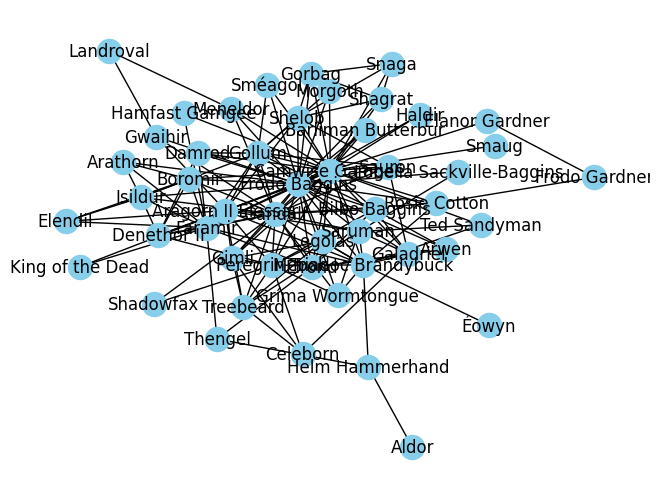

In [203]:
# Create a graph from a pandas dataframe
import networkx as nx 

G =nx.from_pandas_edgelist(relationships_df_throughout_all_books,
                          source="source",
                          target="target", 
                          edge_attr="value",
                          create_using=nx.Graph())

pos= nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

## Graph visualization Python - Pyvis

In [204]:
net= Network(notebook = True, width="1300px", height="700px", bgcolor="#000000", font_color="#ffffff")

node_degree=dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("lord_of_rings.html")

lord_of_rings.html


In [212]:
import community as community_louvain
communities= community_louvain.best_partition(G)

nx.set_node_attributes(G, communities, 'group')

com_net= Network(notebook = True,  width="1300px", height="700px", bgcolor="#000000", font_color="#ffffff")
com_net.from_nx(G)
com_net.show("lord_of_rings_comminities.html")

AttributeError: module 'community' has no attribute 'best_partition'